Goal is to create word vectors from a game of thrones dataset and analyze them to see semantic similarity.


# Step 0: Importing the dependencies:

In [1]:
from __future__ import absolute_import, division, print_function
#future is the missing compatibility layer between python 2 and 3. 

In [2]:
import codecs #to do word encoding
import glob #finds all pathnames matching a pattern, like regex. to effectively search for large text
import logging  #log events for libraries
import multiprocessing #concurrency: a way of running multiple threads and having each thread run a differen process. it's a way of running your program faster
import os #dealing with operating system, like reading file
import pprint #pretty print, human readable
import re #regular expressions

In [3]:
import nltk #importing natural language toolkit
import gensim.models.word2vec as w2v #word 2 vec
import sklearn.manifold #dimensionality reduction #the vectors are going to be multidimensional
import numpy as np #math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
#set up logging:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
#nltk tokenize the sentences: exm:
nltk.download('punkt')

from nltk import word_tokenize,sent_tokenize, pos_tag

sentence = ''''At eight oclock on Thursday morning Arthur didn't feel very good'''

tokens = nltk.word_tokenize(sentence)

tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nevinyilmaz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


["'At",
 'eight',
 'oclock',
 'on',
 'Thursday',
 'morning',
 'Arthur',
 'did',
 "n't",
 'feel',
 'very',
 'good']

# Step 1: Process data

In [7]:
nltk.download("punkt") #pretrained tokenizer
nltk.download("stopwords") # words like, and, the an, a, of
#we want to remove those words so the vectors we create are more accurate

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nevinyilmaz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nevinyilmaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Combine the books into one string:
We need to do this because we want to have one corpus for all of these books

In [8]:
book_filenames = sorted(glob.glob("*.txt"))

print("Found books:")
book_filenames

Found books:


['got1.txt', 'got2.txt', 'got3.txt', 'got4.txt', 'got5.txt']

In [9]:
#initialize a raw corpus, we'll add all text to this file
corpus_raw = u'' #we start with u, because it's a unicode, and we want to convert into utf-8
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("corpus is now {0} characters long".format(len(corpus_raw)))
    print()
    
#for each book, read it, open it in utf-8 format, add it to the corpus_raw

Reading 'got1.txt'...
corpus is now 1770659 characters long

Reading 'got2.txt'...
corpus is now 4071041 characters long

Reading 'got3.txt'...
corpus is now 6391405 characters long

Reading 'got4.txt'...
corpus is now 8107945 characters long

Reading 'got5.txt'...
corpus is now 9719485 characters long



### Split the corpus into sentences:

In [10]:
#load the trained model
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
#convert into list of words
#remove unnecessary characters, split into words

def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]", " ", raw)
    words = clean.split()
    return words
#"[^a-zA-Z]": match all the stings that contain a non-letter
#"^[a-zA-Z]": means match all the strings with a letter

In [13]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(raw_sentences[5])

Heraldic crest by Virginia Norey.


In [15]:
print(sentence_to_wordlist(raw_sentences[5]))

['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [16]:
sentences[5]

['Heraldic', 'crest', 'by', 'Virginia', 'Norey']

In [17]:
#count tokens, each one being a sentence
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


# Step 2: Build the model:

In [18]:
num_features = 300 #dimensionality of the resulting word vectors
min_word_count = 3
num_workers = multiprocessing.cpu_count()# number of threads to run in parallel
context_size = 7
downsampling = 1e-3 #downsamle setting for frequent words = how often to use
seed = 1

In [19]:
thrones2vec = w2v.Word2Vec(sg=1,
                          seed=seed,
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count, 
                          window=context_size, 
                          sample=downsampling)
#sg=1: If 1, skip-gram is employed; otherwise, CBOW is used.
#workers=num_workers:Use these many worker threads to train the model (=faster training with multicore machines).
#size=num_features: Dimensionality of the feature vectors.
#min_count=min_word_count:  Ignores all words with total frequency lower than this.
#window=context_size: The maximum distance between the current and predicted word within a sentence.
#sample=downsampling:  The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).


In [20]:
thrones2vec.build_vocab(sentences) # the new words in `sentences` will be added to model's vocab.

2018-03-29 13:51:44,540 : INFO : collecting all words and their counts
2018-03-29 13:51:44,542 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-03-29 13:51:44,585 : INFO : PROGRESS: at sentence #10000, processed 140984 words, keeping 10280 word types
2018-03-29 13:51:44,638 : INFO : PROGRESS: at sentence #20000, processed 279730 words, keeping 13558 word types
2018-03-29 13:51:44,683 : INFO : PROGRESS: at sentence #30000, processed 420336 words, keeping 16598 word types
2018-03-29 13:51:44,718 : INFO : PROGRESS: at sentence #40000, processed 556581 words, keeping 18324 word types
2018-03-29 13:51:44,752 : INFO : PROGRESS: at sentence #50000, processed 686247 words, keeping 19714 word types
2018-03-29 13:51:44,797 : INFO : PROGRESS: at sentence #60000, processed 828497 words, keeping 21672 word types
2018-03-29 13:51:44,843 : INFO : PROGRESS: at sentence #70000, processed 973830 words, keeping 23093 word types
2018-03-29 13:51:44,886 : INFO : PROGRESS: at 

In [21]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17277


# Step 3: start training:

In [22]:
thrones2vec.train(sentences, total_words=token_count, epochs=100)

2018-03-29 13:52:15,833 : INFO : training model with 4 workers on 17277 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2018-03-29 13:52:16,976 : INFO : EPOCH 1 - PROGRESS: at 13.74% words, 173827 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:52:18,009 : INFO : EPOCH 1 - PROGRESS: at 27.45% words, 179911 words/s, in_qsize 8, out_qsize 0
2018-03-29 13:52:19,114 : INFO : EPOCH 1 - PROGRESS: at 42.28% words, 183007 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:52:20,128 : INFO : EPOCH 1 - PROGRESS: at 55.47% words, 183029 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:52:21,131 : INFO : EPOCH 1 - PROGRESS: at 69.74% words, 186286 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:52:22,160 : INFO : EPOCH 1 - PROGRESS: at 81.83% words, 182807 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:52:23,183 : INFO : EPOCH 1 - PROGRESS: at 91.16% words, 175016 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:52:24,024 : INFO : worker thread finished; awaiting finish of 3 mo

2018-03-29 13:53:08,621 : INFO : EPOCH 7 - PROGRESS: at 13.74% words, 178093 words/s, in_qsize 8, out_qsize 1
2018-03-29 13:53:09,723 : INFO : EPOCH 7 - PROGRESS: at 29.10% words, 187205 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:53:10,796 : INFO : EPOCH 7 - PROGRESS: at 40.09% words, 173078 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:53:11,817 : INFO : EPOCH 7 - PROGRESS: at 53.82% words, 176877 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:53:12,854 : INFO : EPOCH 7 - PROGRESS: at 65.35% words, 172948 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:53:13,878 : INFO : EPOCH 7 - PROGRESS: at 73.59% words, 163192 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:53:14,916 : INFO : EPOCH 7 - PROGRESS: at 82.38% words, 156919 words/s, in_qsize 8, out_qsize 0
2018-03-29 13:53:15,921 : INFO : EPOCH 7 - PROGRESS: at 91.71% words, 153660 words/s, in_qsize 8, out_qsize 0
2018-03-29 13:53:16,631 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-29 13:53:16,638 : INF

2018-03-29 13:54:01,203 : INFO : EPOCH 13 - PROGRESS: at 9.34% words, 125672 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:54:02,266 : INFO : EPOCH 13 - PROGRESS: at 18.66% words, 124317 words/s, in_qsize 8, out_qsize 1
2018-03-29 13:54:03,306 : INFO : EPOCH 13 - PROGRESS: at 29.65% words, 132427 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:54:04,361 : INFO : EPOCH 13 - PROGRESS: at 41.73% words, 139603 words/s, in_qsize 8, out_qsize 0
2018-03-29 13:54:05,440 : INFO : EPOCH 13 - PROGRESS: at 53.27% words, 141833 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:54:06,456 : INFO : EPOCH 13 - PROGRESS: at 63.16% words, 141110 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:54:07,465 : INFO : EPOCH 13 - PROGRESS: at 73.59% words, 141612 words/s, in_qsize 6, out_qsize 1
2018-03-29 13:54:08,471 : INFO : EPOCH 13 - PROGRESS: at 86.21% words, 145769 words/s, in_qsize 8, out_qsize 0
2018-03-29 13:54:09,387 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-29 13:54:09,40

2018-03-29 13:54:52,612 : INFO : EPOCH - 18 : training on 1818103 raw words (1405088 effective words) took 8.5s, 166043 effective words/s
2018-03-29 13:54:53,666 : INFO : EPOCH 19 - PROGRESS: at 13.74% words, 184798 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:54:54,675 : INFO : EPOCH 19 - PROGRESS: at 29.10% words, 199257 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:54:55,681 : INFO : EPOCH 19 - PROGRESS: at 43.93% words, 201895 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:54:56,705 : INFO : EPOCH 19 - PROGRESS: at 54.37% words, 187263 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:54:57,726 : INFO : EPOCH 19 - PROGRESS: at 68.10% words, 187602 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:54:58,753 : INFO : EPOCH 19 - PROGRESS: at 82.91% words, 190125 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:54:59,800 : INFO : EPOCH 19 - PROGRESS: at 95.55% words, 187042 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:55:00,013 : INFO : worker thread finished; awaiting finish of 3 more th

2018-03-29 13:55:49,025 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-29 13:55:49,032 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-29 13:55:49,039 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-29 13:55:49,092 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-29 13:55:49,094 : INFO : EPOCH - 24 : training on 1818103 raw words (1404583 effective words) took 10.3s, 135768 effective words/s
2018-03-29 13:55:50,125 : INFO : EPOCH 25 - PROGRESS: at 8.79% words, 121126 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:55:51,168 : INFO : EPOCH 25 - PROGRESS: at 18.11% words, 123250 words/s, in_qsize 8, out_qsize 0
2018-03-29 13:55:52,168 : INFO : EPOCH 25 - PROGRESS: at 32.95% words, 151246 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:55:53,169 : INFO : EPOCH 25 - PROGRESS: at 47.23% words, 163331 words/s, in_qsize 8, out_qsize 0
2018-03-29 13:55:54,200 : INFO : EPOCH 25 - PROGRESS: 

2018-03-29 13:56:38,555 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-29 13:56:38,555 : INFO : EPOCH - 30 : training on 1818103 raw words (1405326 effective words) took 8.4s, 167557 effective words/s
2018-03-29 13:56:39,729 : INFO : EPOCH 31 - PROGRESS: at 11.54% words, 139731 words/s, in_qsize 6, out_qsize 1
2018-03-29 13:56:40,915 : INFO : EPOCH 31 - PROGRESS: at 22.51% words, 134760 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:56:41,952 : INFO : EPOCH 31 - PROGRESS: at 32.95% words, 136968 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:56:42,971 : INFO : EPOCH 31 - PROGRESS: at 45.58% words, 145609 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:56:43,987 : INFO : EPOCH 31 - PROGRESS: at 58.76% words, 152588 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:56:45,099 : INFO : EPOCH 31 - PROGRESS: at 70.29% words, 151396 words/s, in_qsize 6, out_qsize 1
2018-03-29 13:56:46,164 : INFO : EPOCH 31 - PROGRESS: at 80.73% words, 149476 words/s, in_qsize 7, out_qs

2018-03-29 13:57:33,165 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-29 13:57:33,203 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-29 13:57:33,211 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-29 13:57:33,279 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-29 13:57:33,280 : INFO : EPOCH - 36 : training on 1818103 raw words (1404349 effective words) took 8.6s, 163829 effective words/s
2018-03-29 13:57:34,301 : INFO : EPOCH 37 - PROGRESS: at 13.74% words, 190788 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:57:35,364 : INFO : EPOCH 37 - PROGRESS: at 25.26% words, 171144 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:57:36,416 : INFO : EPOCH 37 - PROGRESS: at 37.89% words, 170460 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:57:37,421 : INFO : EPOCH 37 - PROGRESS: at 49.98% words, 170086 words/s, in_qsize 8, out_qsize 0
2018-03-29 13:57:38,548 : INFO : EPOCH 37 - PROGRESS: 

2018-03-29 13:58:25,353 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-29 13:58:25,449 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-29 13:58:25,459 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-29 13:58:25,467 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-29 13:58:25,469 : INFO : EPOCH - 42 : training on 1818103 raw words (1405084 effective words) took 8.9s, 157673 effective words/s
2018-03-29 13:58:26,495 : INFO : EPOCH 43 - PROGRESS: at 13.74% words, 190061 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:58:27,496 : INFO : EPOCH 43 - PROGRESS: at 28.55% words, 199037 words/s, in_qsize 8, out_qsize 0
2018-03-29 13:58:28,509 : INFO : EPOCH 43 - PROGRESS: at 42.83% words, 198798 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:58:29,512 : INFO : EPOCH 43 - PROGRESS: at 56.02% words, 195322 words/s, in_qsize 8, out_qsize 0
2018-03-29 13:58:30,553 : INFO : EPOCH 43 - PROGRESS: 

2018-03-29 13:59:15,876 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-29 13:59:15,916 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-29 13:59:15,939 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-29 13:59:15,940 : INFO : EPOCH - 48 : training on 1818103 raw words (1405141 effective words) took 9.4s, 150039 effective words/s
2018-03-29 13:59:16,979 : INFO : EPOCH 49 - PROGRESS: at 13.74% words, 187737 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:59:18,090 : INFO : EPOCH 49 - PROGRESS: at 26.90% words, 176708 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:59:19,096 : INFO : EPOCH 49 - PROGRESS: at 40.64% words, 181611 words/s, in_qsize 8, out_qsize 0
2018-03-29 13:59:20,119 : INFO : EPOCH 49 - PROGRESS: at 54.37% words, 183318 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:59:21,154 : INFO : EPOCH 49 - PROGRESS: at 68.64% words, 185484 words/s, in_qsize 7, out_qsize 0
2018-03-29 13:59:22,172 : INFO : E

2018-03-29 14:00:05,803 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-29 14:00:05,882 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-29 14:00:05,883 : INFO : EPOCH - 54 : training on 1818103 raw words (1404435 effective words) took 7.5s, 187101 effective words/s
2018-03-29 14:00:06,976 : INFO : EPOCH 55 - PROGRESS: at 13.74% words, 178959 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:00:07,986 : INFO : EPOCH 55 - PROGRESS: at 28.55% words, 192230 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:00:09,026 : INFO : EPOCH 55 - PROGRESS: at 39.54% words, 177829 words/s, in_qsize 8, out_qsize 0
2018-03-29 14:00:10,037 : INFO : EPOCH 55 - PROGRESS: at 51.07% words, 173493 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:00:11,095 : INFO : EPOCH 55 - PROGRESS: at 60.96% words, 165001 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:00:12,120 : INFO : EPOCH 55 - PROGRESS: at 72.49% words, 163765 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:

2018-03-29 14:00:56,646 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-29 14:00:56,646 : INFO : EPOCH - 60 : training on 1818103 raw words (1404518 effective words) took 8.1s, 173473 effective words/s
2018-03-29 14:00:57,681 : INFO : EPOCH 61 - PROGRESS: at 12.09% words, 165524 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:00:58,707 : INFO : EPOCH 61 - PROGRESS: at 23.61% words, 161510 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:00:59,725 : INFO : EPOCH 61 - PROGRESS: at 31.85% words, 145862 words/s, in_qsize 8, out_qsize 0
2018-03-29 14:01:00,739 : INFO : EPOCH 61 - PROGRESS: at 42.83% words, 147366 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:01:01,825 : INFO : EPOCH 61 - PROGRESS: at 54.37% words, 147847 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:01:02,826 : INFO : EPOCH 61 - PROGRESS: at 65.35% words, 148978 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:01:03,852 : INFO : EPOCH 61 - PROGRESS: at 77.99% words, 152353 words/s, in_qsize 7, out_qs

2018-03-29 14:01:47,580 : INFO : EPOCH 67 - PROGRESS: at 21.41% words, 147340 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:01:48,620 : INFO : EPOCH 67 - PROGRESS: at 33.50% words, 152910 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:01:49,685 : INFO : EPOCH 67 - PROGRESS: at 47.23% words, 160127 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:01:50,712 : INFO : EPOCH 67 - PROGRESS: at 62.06% words, 168769 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:01:51,729 : INFO : EPOCH 67 - PROGRESS: at 75.24% words, 170920 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:01:52,732 : INFO : EPOCH 67 - PROGRESS: at 89.51% words, 174868 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:01:53,407 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-29 14:01:53,444 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-29 14:01:53,475 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-29 14:01:53,523 : INFO : worker thread finished; awai

2018-03-29 14:02:39,585 : INFO : EPOCH 73 - PROGRESS: at 30.75% words, 141768 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:02:40,618 : INFO : EPOCH 73 - PROGRESS: at 45.03% words, 155098 words/s, in_qsize 8, out_qsize 0
2018-03-29 14:02:41,645 : INFO : EPOCH 73 - PROGRESS: at 57.12% words, 157227 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:02:42,696 : INFO : EPOCH 73 - PROGRESS: at 69.74% words, 159184 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:02:43,697 : INFO : EPOCH 73 - PROGRESS: at 82.91% words, 162725 words/s, in_qsize 8, out_qsize 0
2018-03-29 14:02:44,729 : INFO : EPOCH 73 - PROGRESS: at 94.45% words, 161902 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:02:44,999 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-29 14:02:45,039 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-29 14:02:45,049 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-29 14:02:45,103 : INFO : worker thread finished; awai

2018-03-29 14:03:31,783 : INFO : EPOCH 79 - PROGRESS: at 83.46% words, 187196 words/s, in_qsize 8, out_qsize 0
2018-03-29 14:03:32,792 : INFO : EPOCH 79 - PROGRESS: at 98.35% words, 189863 words/s, in_qsize 3, out_qsize 1
2018-03-29 14:03:32,793 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-29 14:03:32,832 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-29 14:03:32,858 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-29 14:03:32,891 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-29 14:03:32,892 : INFO : EPOCH - 79 : training on 1818103 raw words (1404402 effective words) took 7.4s, 190371 effective words/s
2018-03-29 14:03:33,913 : INFO : EPOCH 80 - PROGRESS: at 13.19% words, 183333 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:03:34,946 : INFO : EPOCH 80 - PROGRESS: at 26.90% words, 184912 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:03:35,967 : INFO : EPOCH 80 - PROGRESS: 

2018-03-29 14:04:23,173 : INFO : EPOCH 85 - PROGRESS: at 96.65% words, 164439 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:04:23,273 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-29 14:04:23,335 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-29 14:04:23,353 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-29 14:04:23,371 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-29 14:04:23,372 : INFO : EPOCH - 85 : training on 1818103 raw words (1404356 effective words) took 8.5s, 166109 effective words/s
2018-03-29 14:04:24,390 : INFO : EPOCH 86 - PROGRESS: at 9.34% words, 129776 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:04:25,416 : INFO : EPOCH 86 - PROGRESS: at 22.51% words, 155271 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:04:26,469 : INFO : EPOCH 86 - PROGRESS: at 34.59% words, 157484 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:04:27,492 : INFO : EPOCH 86 - PROGRESS: a

2018-03-29 14:05:13,430 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-29 14:05:13,430 : INFO : EPOCH - 91 : training on 1818103 raw words (1404417 effective words) took 7.1s, 196890 effective words/s
2018-03-29 14:05:14,526 : INFO : EPOCH 92 - PROGRESS: at 13.74% words, 179239 words/s, in_qsize 8, out_qsize 0
2018-03-29 14:05:15,594 : INFO : EPOCH 92 - PROGRESS: at 29.10% words, 190802 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:05:16,596 : INFO : EPOCH 92 - PROGRESS: at 43.38% words, 193842 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:05:17,624 : INFO : EPOCH 92 - PROGRESS: at 57.67% words, 194360 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:05:18,634 : INFO : EPOCH 92 - PROGRESS: at 71.94% words, 195153 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:05:19,644 : INFO : EPOCH 92 - PROGRESS: at 85.11% words, 193196 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:05:20,602 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-29 14:

2018-03-29 14:06:04,606 : INFO : EPOCH - 97 : training on 1818103 raw words (1403856 effective words) took 9.3s, 151335 effective words/s
2018-03-29 14:06:05,664 : INFO : EPOCH 98 - PROGRESS: at 11.54% words, 154603 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:06:06,703 : INFO : EPOCH 98 - PROGRESS: at 20.31% words, 136768 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:06:07,827 : INFO : EPOCH 98 - PROGRESS: at 31.30% words, 137111 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:06:08,838 : INFO : EPOCH 98 - PROGRESS: at 40.09% words, 133652 words/s, in_qsize 8, out_qsize 0
2018-03-29 14:06:09,875 : INFO : EPOCH 98 - PROGRESS: at 51.62% words, 138110 words/s, in_qsize 8, out_qsize 0
2018-03-29 14:06:10,890 : INFO : EPOCH 98 - PROGRESS: at 64.26% words, 144234 words/s, in_qsize 6, out_qsize 1
2018-03-29 14:06:11,944 : INFO : EPOCH 98 - PROGRESS: at 77.44% words, 148687 words/s, in_qsize 7, out_qsize 0
2018-03-29 14:06:12,946 : INFO : EPOCH 98 - PROGRESS: at 86.21% words, 145555 words/s

(140441749, 181810300)

In [23]:
#save file
if not os.path.exists("trained"):
    os.makedirs("trained")

In [24]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2018-03-29 14:06:50,611 : INFO : saving Word2Vec object under trained/thrones2vec.w2v, separately None
2018-03-29 14:06:50,614 : INFO : not storing attribute vectors_norm
2018-03-29 14:06:50,621 : INFO : not storing attribute cum_table
2018-03-29 14:06:51,361 : INFO : saved trained/thrones2vec.w2v


In [25]:
#load model
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

2018-03-29 14:06:53,439 : INFO : loading Word2Vec object from trained/thrones2vec.w2v
2018-03-29 14:06:53,830 : INFO : loading wv recursively from trained/thrones2vec.w2v.wv.* with mmap=None
2018-03-29 14:06:53,831 : INFO : setting ignored attribute vectors_norm to None
2018-03-29 14:06:53,831 : INFO : loading vocabulary recursively from trained/thrones2vec.w2v.vocabulary.* with mmap=None
2018-03-29 14:06:53,832 : INFO : loading trainables recursively from trained/thrones2vec.w2v.trainables.* with mmap=None
2018-03-29 14:06:53,833 : INFO : setting ignored attribute cum_table to None
2018-03-29 14:06:53,834 : INFO : loaded trained/thrones2vec.w2v


In [26]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [27]:
all_word_vectors_matrix = thrones2vec.wv.syn0

/Users/nevinyilmaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [28]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [31]:
#plot the big picture
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [32]:
points.head(10)

,word,x,y
0,This,0.050340,-7.356647
1,edition,-14.148547,14.822982
2,the,2.105602,-2.536510
3,complete,-14.273405,12.022625
4,of,1.660869,-2.145313
5,original,-14.158061,12.636953
6,hardcover,-14.197958,14.859680
7,ONE,-14.572351,20.538973
8,A,1.331774,-3.432854
9,OF,-12.776813,19.163157


In [33]:
sns.set_context("poster")

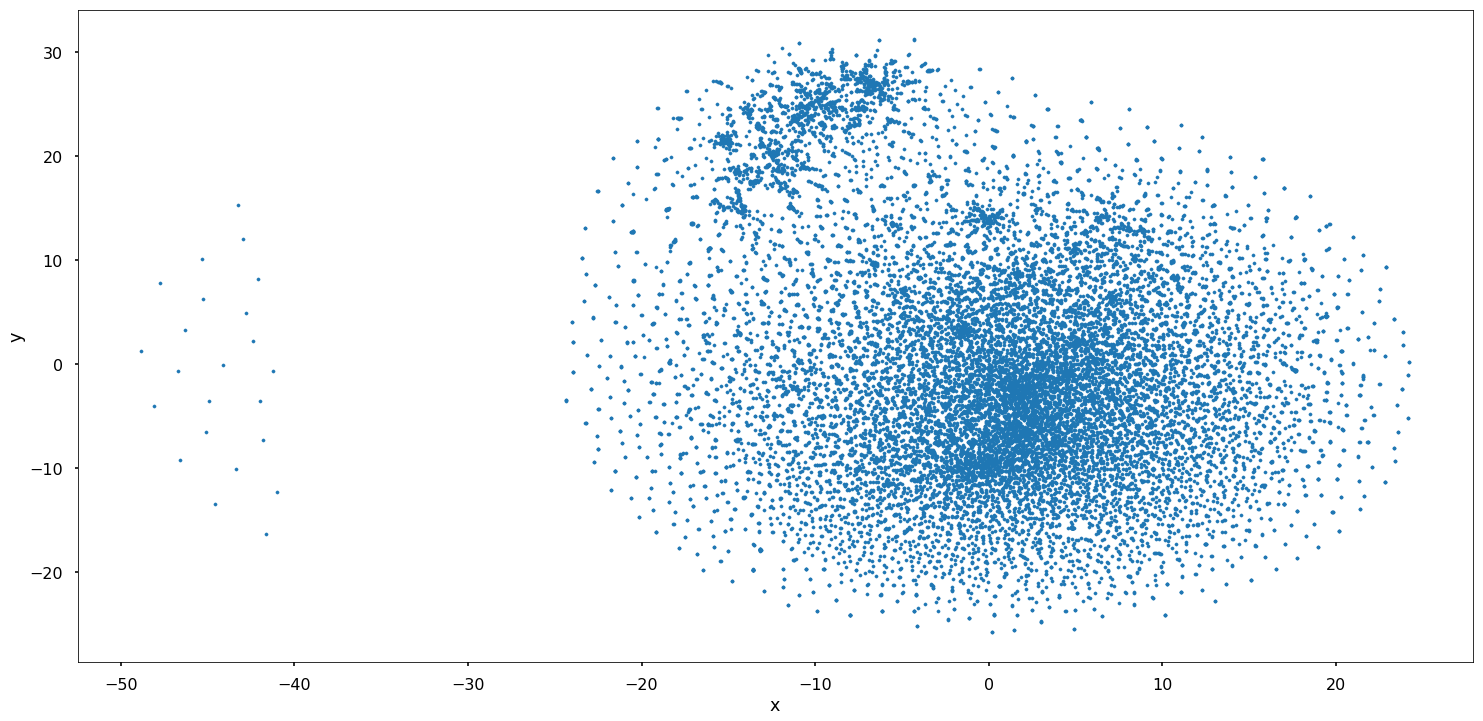

In [49]:
points.plot.scatter("x", "y", s=10, figsize=(25, 12))

In [35]:
#details
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [36]:
print("Range of t-sne viz in x = {}, {} and y = {}, {}" .format(min(points.x), max(points.x), min(points.y), max(points.y)))

Range of t-sne viz in x = -48.82141876220703, 24.21062660217285 and y = -25.833988189697266, 31.222572326660156


### Semantic similarities

In [39]:
thrones2vec.most_similar("Stark")

/Users/nevinyilmaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2018-03-29 14:29:59,956 : INFO : precomputing L2-norms of word weight vectors


[('Eddard', 0.6460243463516235),
 ('Winterfell', 0.44764068722724915),
 ('Edrick', 0.43109530210494995),
 ('SHIREI', 0.41956913471221924),
 ('Robb', 0.4129311740398407),
 ('Snowbeard', 0.41181156039237976),
 ('Catelyn', 0.4011295735836029),
 ('Jammos', 0.3979570269584656),
 ('divulge', 0.3942658603191376),
 ('Carolei', 0.38400161266326904)]

In [40]:
thrones2vec.most_similar("Dragons")

/Users/nevinyilmaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Shackles', 0.48342978954315186),
 ('Mother', 0.46328553557395935),
 ('Unburnt', 0.4361386001110077),
 ('Stormborn', 0.39433449506759644),
 ('Daenerys', 0.38818225264549255),
 ('Dance', 0.3763583302497864),
 ('Breaker', 0.3759177029132843),
 ('Munkun', 0.37468186020851135),
 ('Song', 0.34502843022346497),
 ('trademarks', 0.3441073000431061)]

In [41]:
thrones2vec.most_similar("direwolf")

/Users/nevinyilmaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('WIND', 0.45483824610710144),
 ('Ghost', 0.4364742040634155),
 ('wolf', 0.4337453842163086),
 ('SHAGGYDOG', 0.43143510818481445),
 ('EDDISON', 0.41698548197746277),
 ('GHOST', 0.4159802496433258),
 ('DOLOROUS', 0.40591415762901306),
 ('SUMMER', 0.4015659689903259),
 ('TOLLETT', 0.39004361629486084),
 ('EDD', 0.38400354981422424)]

In [42]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [52]:
nearest_similarity_cosmul("Stark", "Winterfell", "Martell") #Leader
nearest_similarity_cosmul("Stark", "Winterfell", "Bolton")  # Head of families
nearest_similarity_cosmul("Arya", "Horseface", "Daenerys") # Nicknames
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun") # Leaders 
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Tyrion", "wine", "dragons")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons") # Mystic/Extinct creatures
nearest_similarity_cosmul("Snow", "Jon", "Ellaria") # Bastards in North/Dorne

Stark is related to Winterfell, as Doran is related to Martell
Stark is related to Winterfell, as Roose is related to Bolton
Arya is related to Horseface, as Stormborn is related to Daenerys
Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as cup is related to wine
Tyrion is related to wine, as Dragonpit is related to dragons
Arya is related to Nymeria, as wyrms is related to dragons
Snow is related to Jon, as Sand is related to Ellaria


/Users/nevinyilmaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


'Sand'

In [45]:
thrones2vec.wv.doesnt_match("Tyrion Daenerys Gendry Bran Jon".split())  #Iron Throne contenders

'Daenerys'

In [47]:
thrones2vec.wv.doesnt_match("Jaime Cersei Robert".split())

'Robert'

In [48]:
 thrones2vec.wv.doesnt_match("Ramsay Jon Ellaria ".split())  #Snow

'Ellaria'